In [1]:
source("common.R")

levels <- c("Activity not limited", "Activity limited a little", "Activity limited a lot")

group_levels <- c('4 to <12 weeks', '12 to <26 weeks', '26 to <39 weeks', 
                  '39 to <52 weeks', '52 to <78 weeks', '52+ weeks', 
                  '78 to <104 weeks', '104+ weeks', 'Unknown duration')

df <-
  read_csv("data/tidy_ons_longcovid.csv", show_col_types = F)%>%
  filter(Domain=="Duration since first (suspected) coronavirus infection")%>%
  filter(Unit=="Thousands")%>%
  select(-Domain, -filename, -`Lower 95% confidence limit`, -`Upper 95% confidence limit`)%>%
  mutate(`Impact on daily activity` = as.factor(`Impact on daily activity`))%>%
  mutate(`Impact on daily activity` = factor(`Impact on daily activity`, levels = levels))%>%
  mutate(Group = factor(Group, levels = group_levels))

df%>%
  arrange(`Week Ending Date`)%>%
  tail

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

NOTE: Either Arial Narrow or Roboto Condensed fonts are required to use these themes.

      Please use hrbrthemes::import_roboto_condensed() to install Roboto Condensed and

      if Arial Narrow is not on your system, please see https://bit.ly/arialnarrow



Impact on daily activity,Group,Estimate,Unit,Week Ending Date,midpoint_date
<fct>,<fct>,<dbl>,<chr>,<date>,<date>
Activity limited a lot,26 to <39 weeks,22,Thousands,2023-03-05,2023-02-19
Activity limited a lot,39 to <52 weeks,43,Thousands,2023-03-05,2023-02-19
Activity limited a lot,52 to <78 weeks,73,Thousands,2023-03-05,2023-02-19
Activity limited a lot,78 to <104 weeks,17,Thousands,2023-03-05,2023-02-19
Activity limited a lot,104+ weeks,175,Thousands,2023-03-05,2023-02-19
Activity limited a lot,Unknown duration,17,Thousands,2023-03-05,2023-02-19


In [2]:
group_levels <- levels(as.factor(df$Group))

df_duration <- 
  data.frame(Group = group_levels)%>%
  filter(Group!="Unknown duration")%>%
  mutate(duration.min = as.integer(parse_number(Group)))%>%
  mutate(duration.max = as.integer(str_match(Group, ".+<([0-9]+)")[,2]))%>%
  mutate(duration.avg = as.integer(duration.min + (duration.max-duration.min)/2))%>%
  arrange(duration.min, duration.max)

df_duration

Group,duration.min,duration.max,duration.avg
<chr>,<int>,<int>,<int>
4 to <12 weeks,4,12,8
12 to <26 weeks,12,26,19
26 to <39 weeks,26,39,32
39 to <52 weeks,39,52,45
52 to <78 weeks,52,78,65
52+ weeks,52,NA,NA
78 to <104 weeks,78,104,91
104+ weeks,104,NA,NA


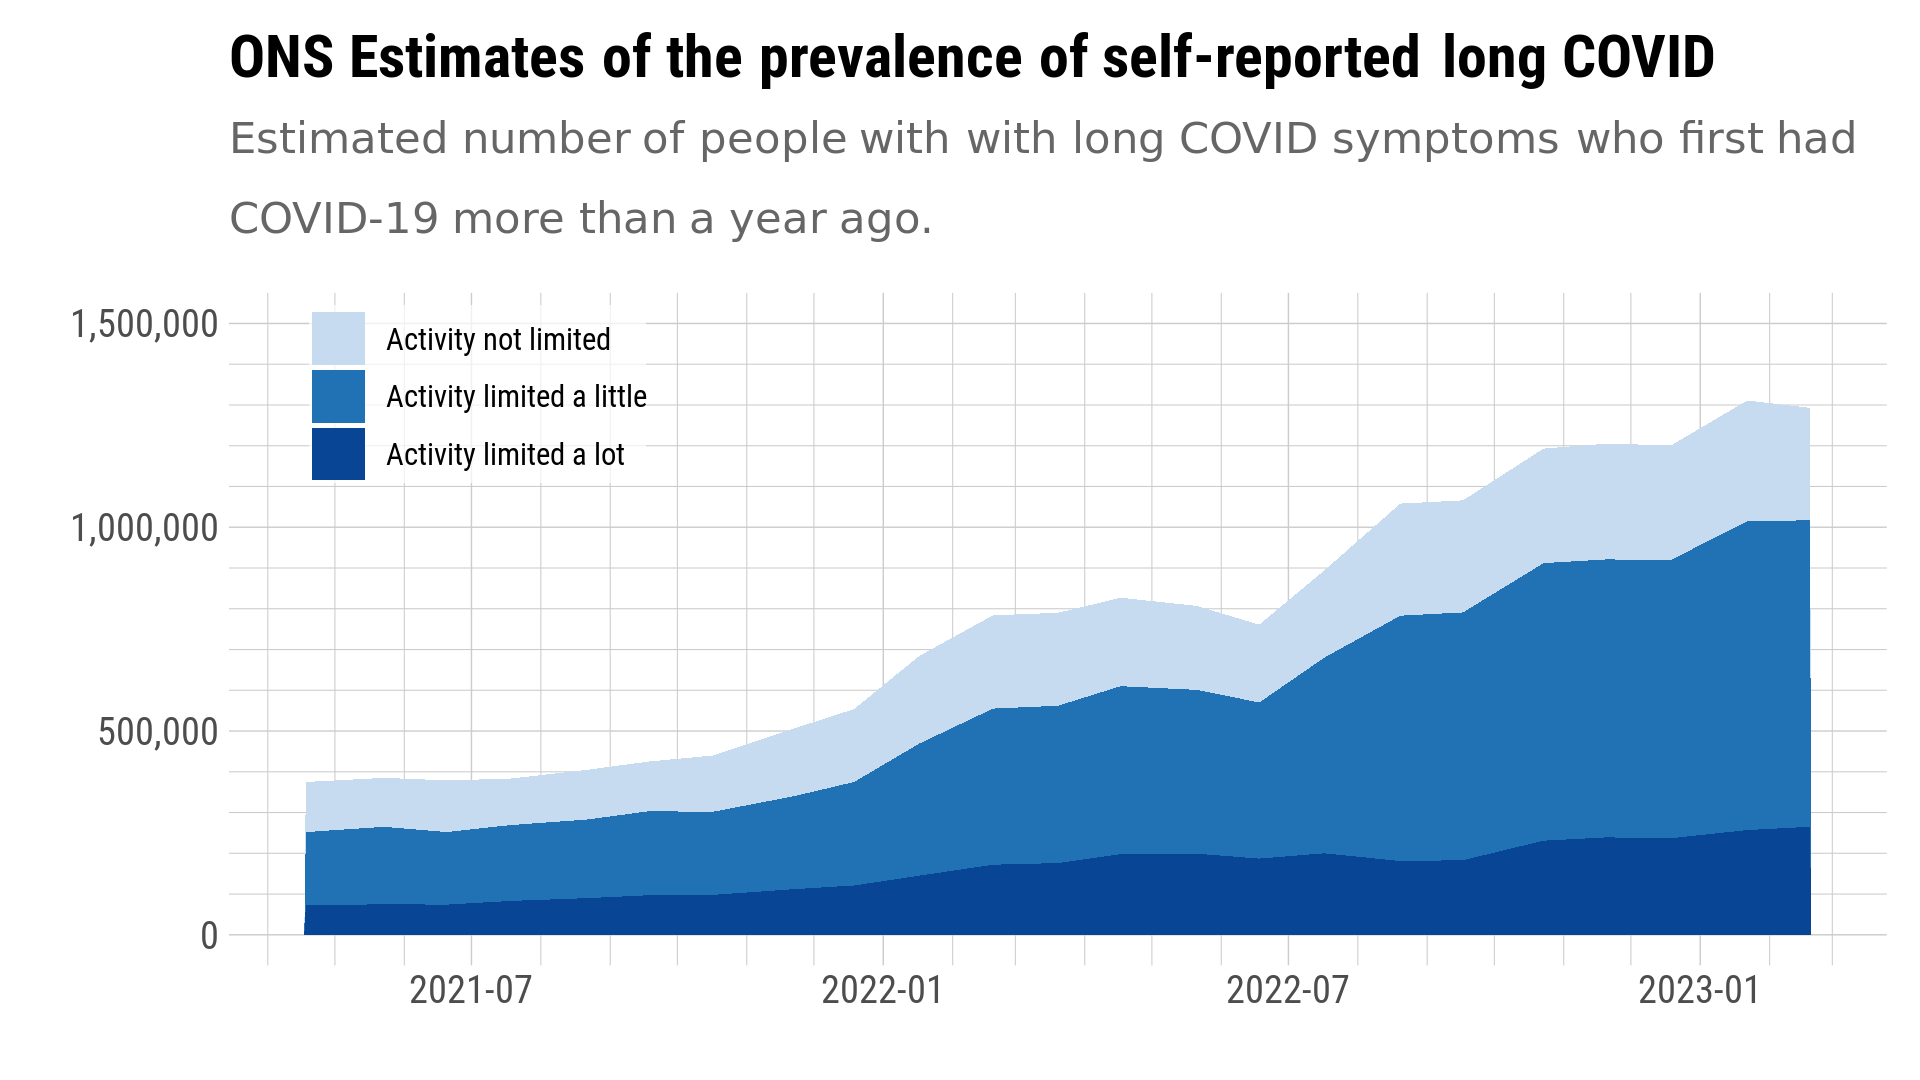

In [3]:
s = 1.
options(repr.plot.width = s*8, repr.plot.height = s*4.5, repr.plot.res = 240/s)

df%>%
  merge(df_duration)%>%
  filter(duration.min >= 52)%>%
  group_by(midpoint_date, `Impact on daily activity`)%>%
  summarise(Estimate = sum(Estimate), na.rm = T, .groups = "drop")%>%
  ggplot(aes(x = midpoint_date, y = Estimate*1000, fill = `Impact on daily activity`)) + 
  labs(title = "ONS Estimates of the prevalence of self-reported long COVID",
       subtitle = "Estimated number of people with with long COVID symptoms who first had<br><br>COVID-19 more than a year ago.",
       fill = "", x = "", y = "") +
  geom_area() +
  scale_fill_manual(values = c('#C6DBEF',  '#2171B5', '#084594')) +
  scale_y_continuous(labels = scales::comma, limits = c(0,1500000), minor_breaks = seq(0, 2e6, 1e5)) +
  scale_x_date(date_minor_breaks = "1 month") +
  theme(legend.position = c(0.15, .85),
        legend.margin=margin(t = -.5, unit='cm'),
        legend.box.background = element_rect(fill = alpha("white", 0.7),
            colour = NA)) +
  savePlot("ONS_LC_long_haulers")


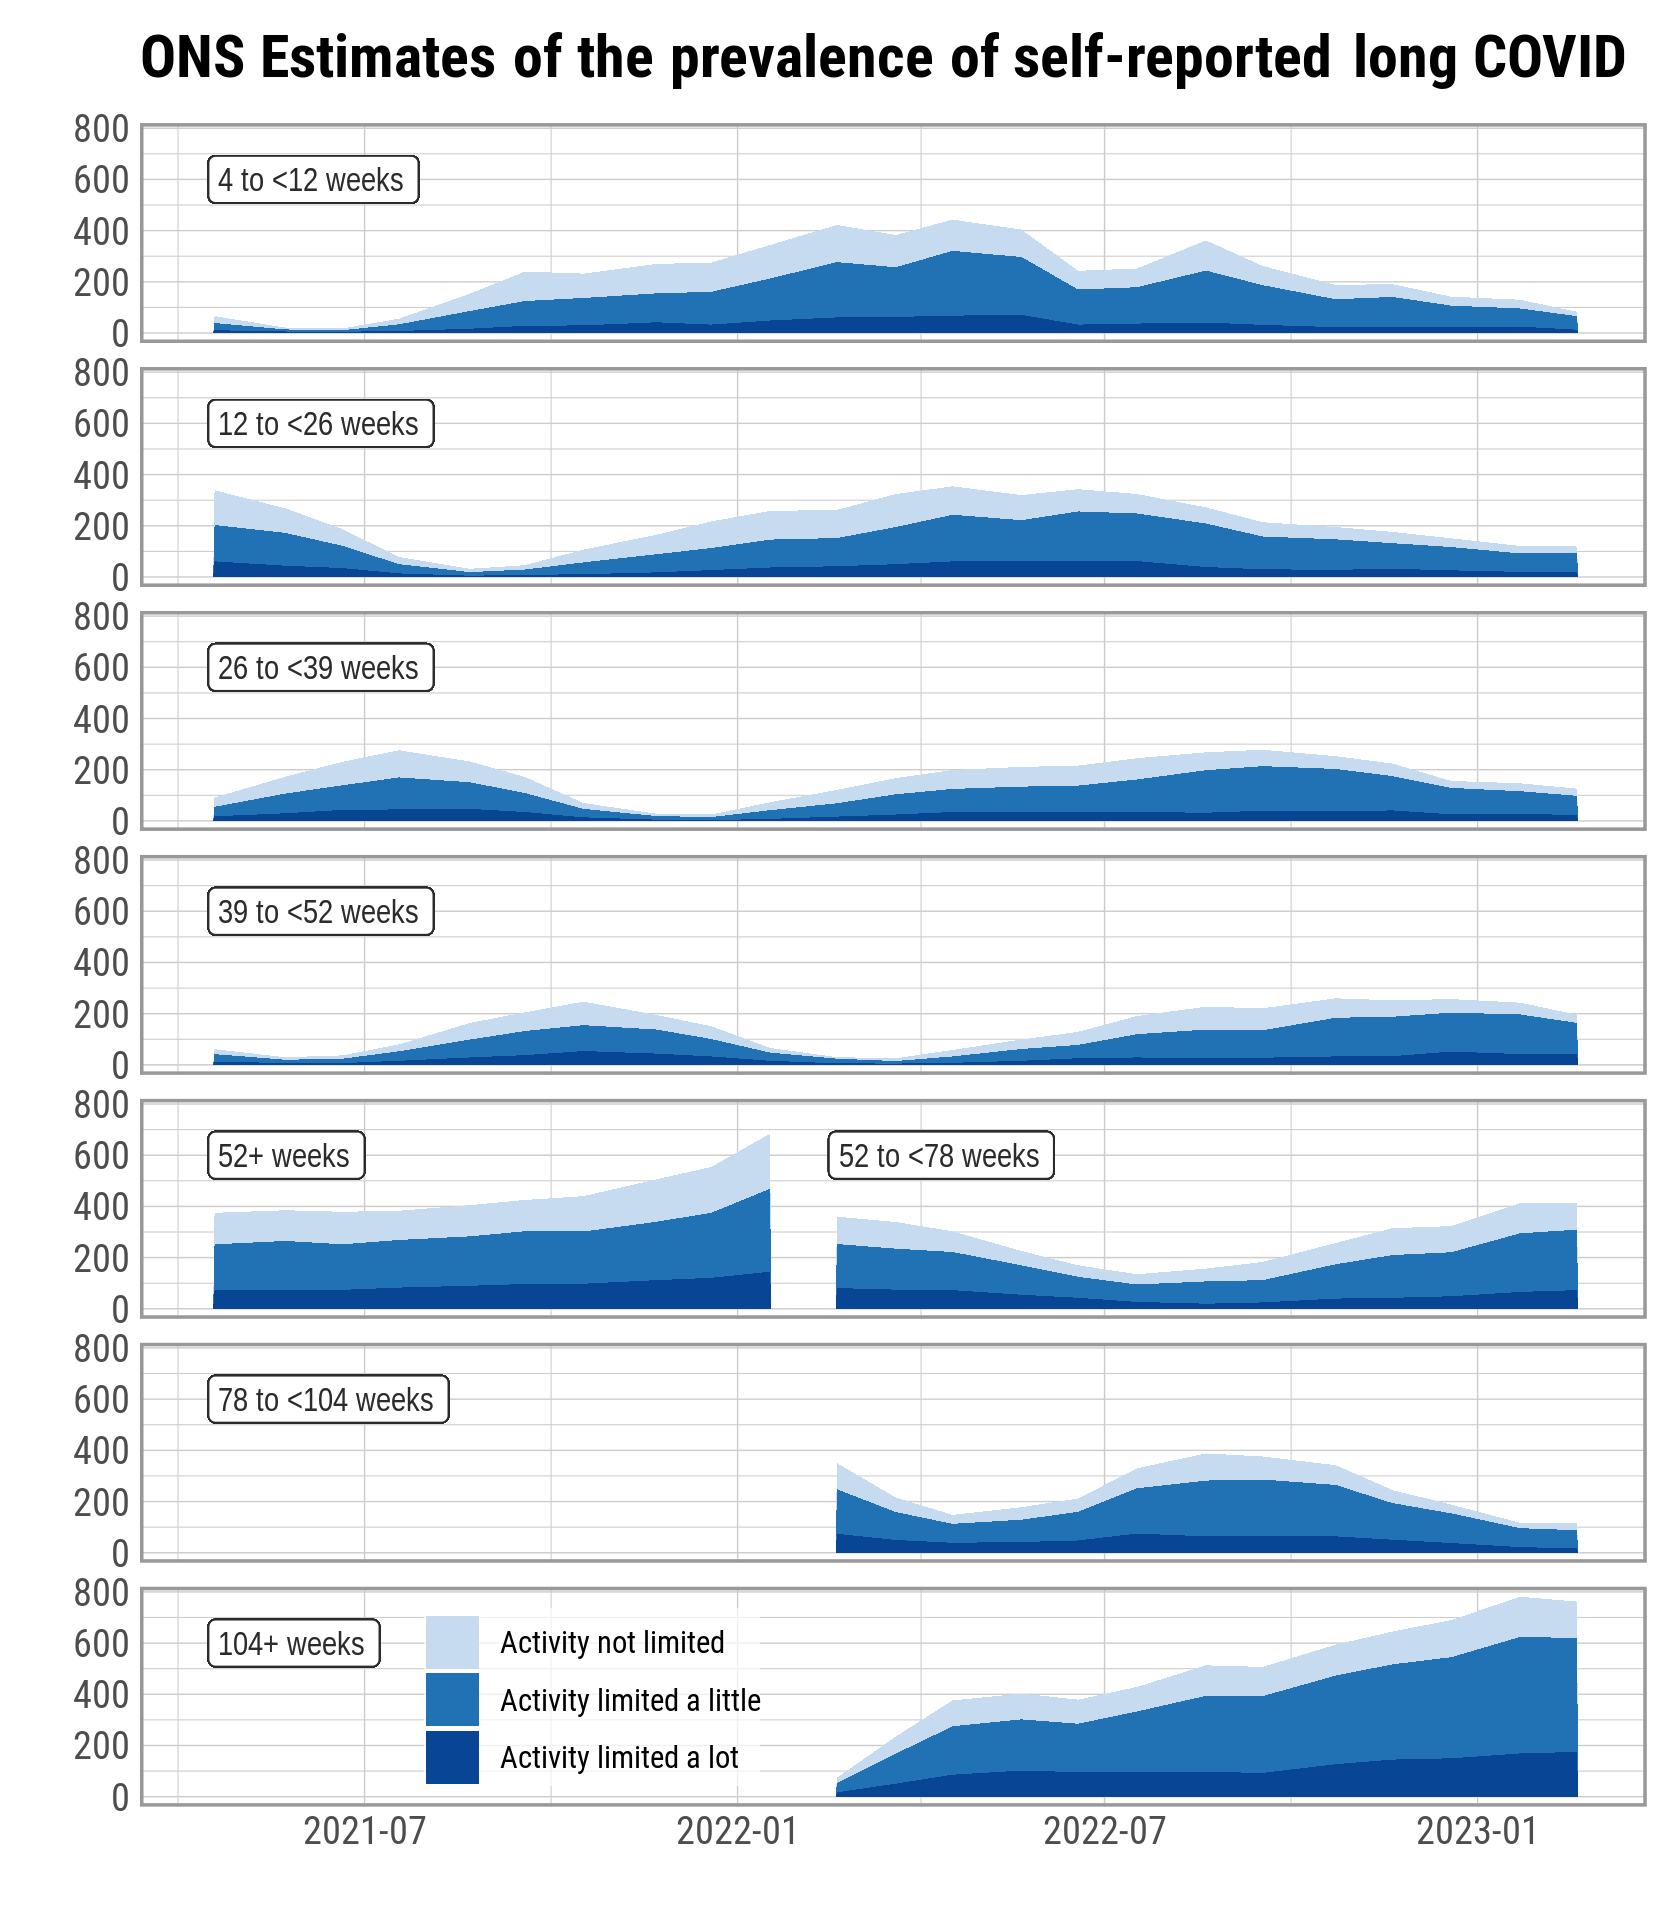

In [4]:
s = 1
options(repr.plot.width = s*7, repr.plot.height = s*8, repr.plot.res = 240/s)

df%>%
  merge(df_duration)%>%
  mutate(cat = ifelse(Group == "52+ weeks", 5, Group))%>%
  mutate(label_pos = as.Date(ifelse(Group == "52 to <78 weeks", "2022-02-15", "2021-04-15")))%>%
  ggplot(aes(x = midpoint_date, y = Estimate,
             group = interaction(Group, `Impact on daily activity`),
             fill = `Impact on daily activity`)) + 
  labs(title = "ONS Estimates of the prevalence of self-reported long COVID",
       #subtitle = "Thousands, by (roughly) estimated date of infection",
       fill = "", x = "", y = "") +
  geom_area() +
  scale_fill_manual(values = c('#C6DBEF',  '#2171B5', '#084594')) +
  scale_y_continuous(breaks = seq(0, 1000, 200)) +
  geom_label(aes(x = label_pos, y = 600, label = Group),
             hjust = 0, fill = "white", alpha = 0.8) +
  facet_wrap(cat~., ncol = 1)+ 
  theme(strip.background = element_blank(),
        strip.text.x = element_blank(),
        panel.spacing = unit(0.5, "lines"),
        panel.border = element_rect(color = "gray60", fill=NA, linewidth=1),
        legend.position = c(0.3, .065),
        legend.margin=margin(t = -.5, unit='cm'),
        legend.box.background = element_rect(fill = alpha("white", 0.7),
            colour = NA)) +
  savePlot("ONS_LC_date_of_survey")

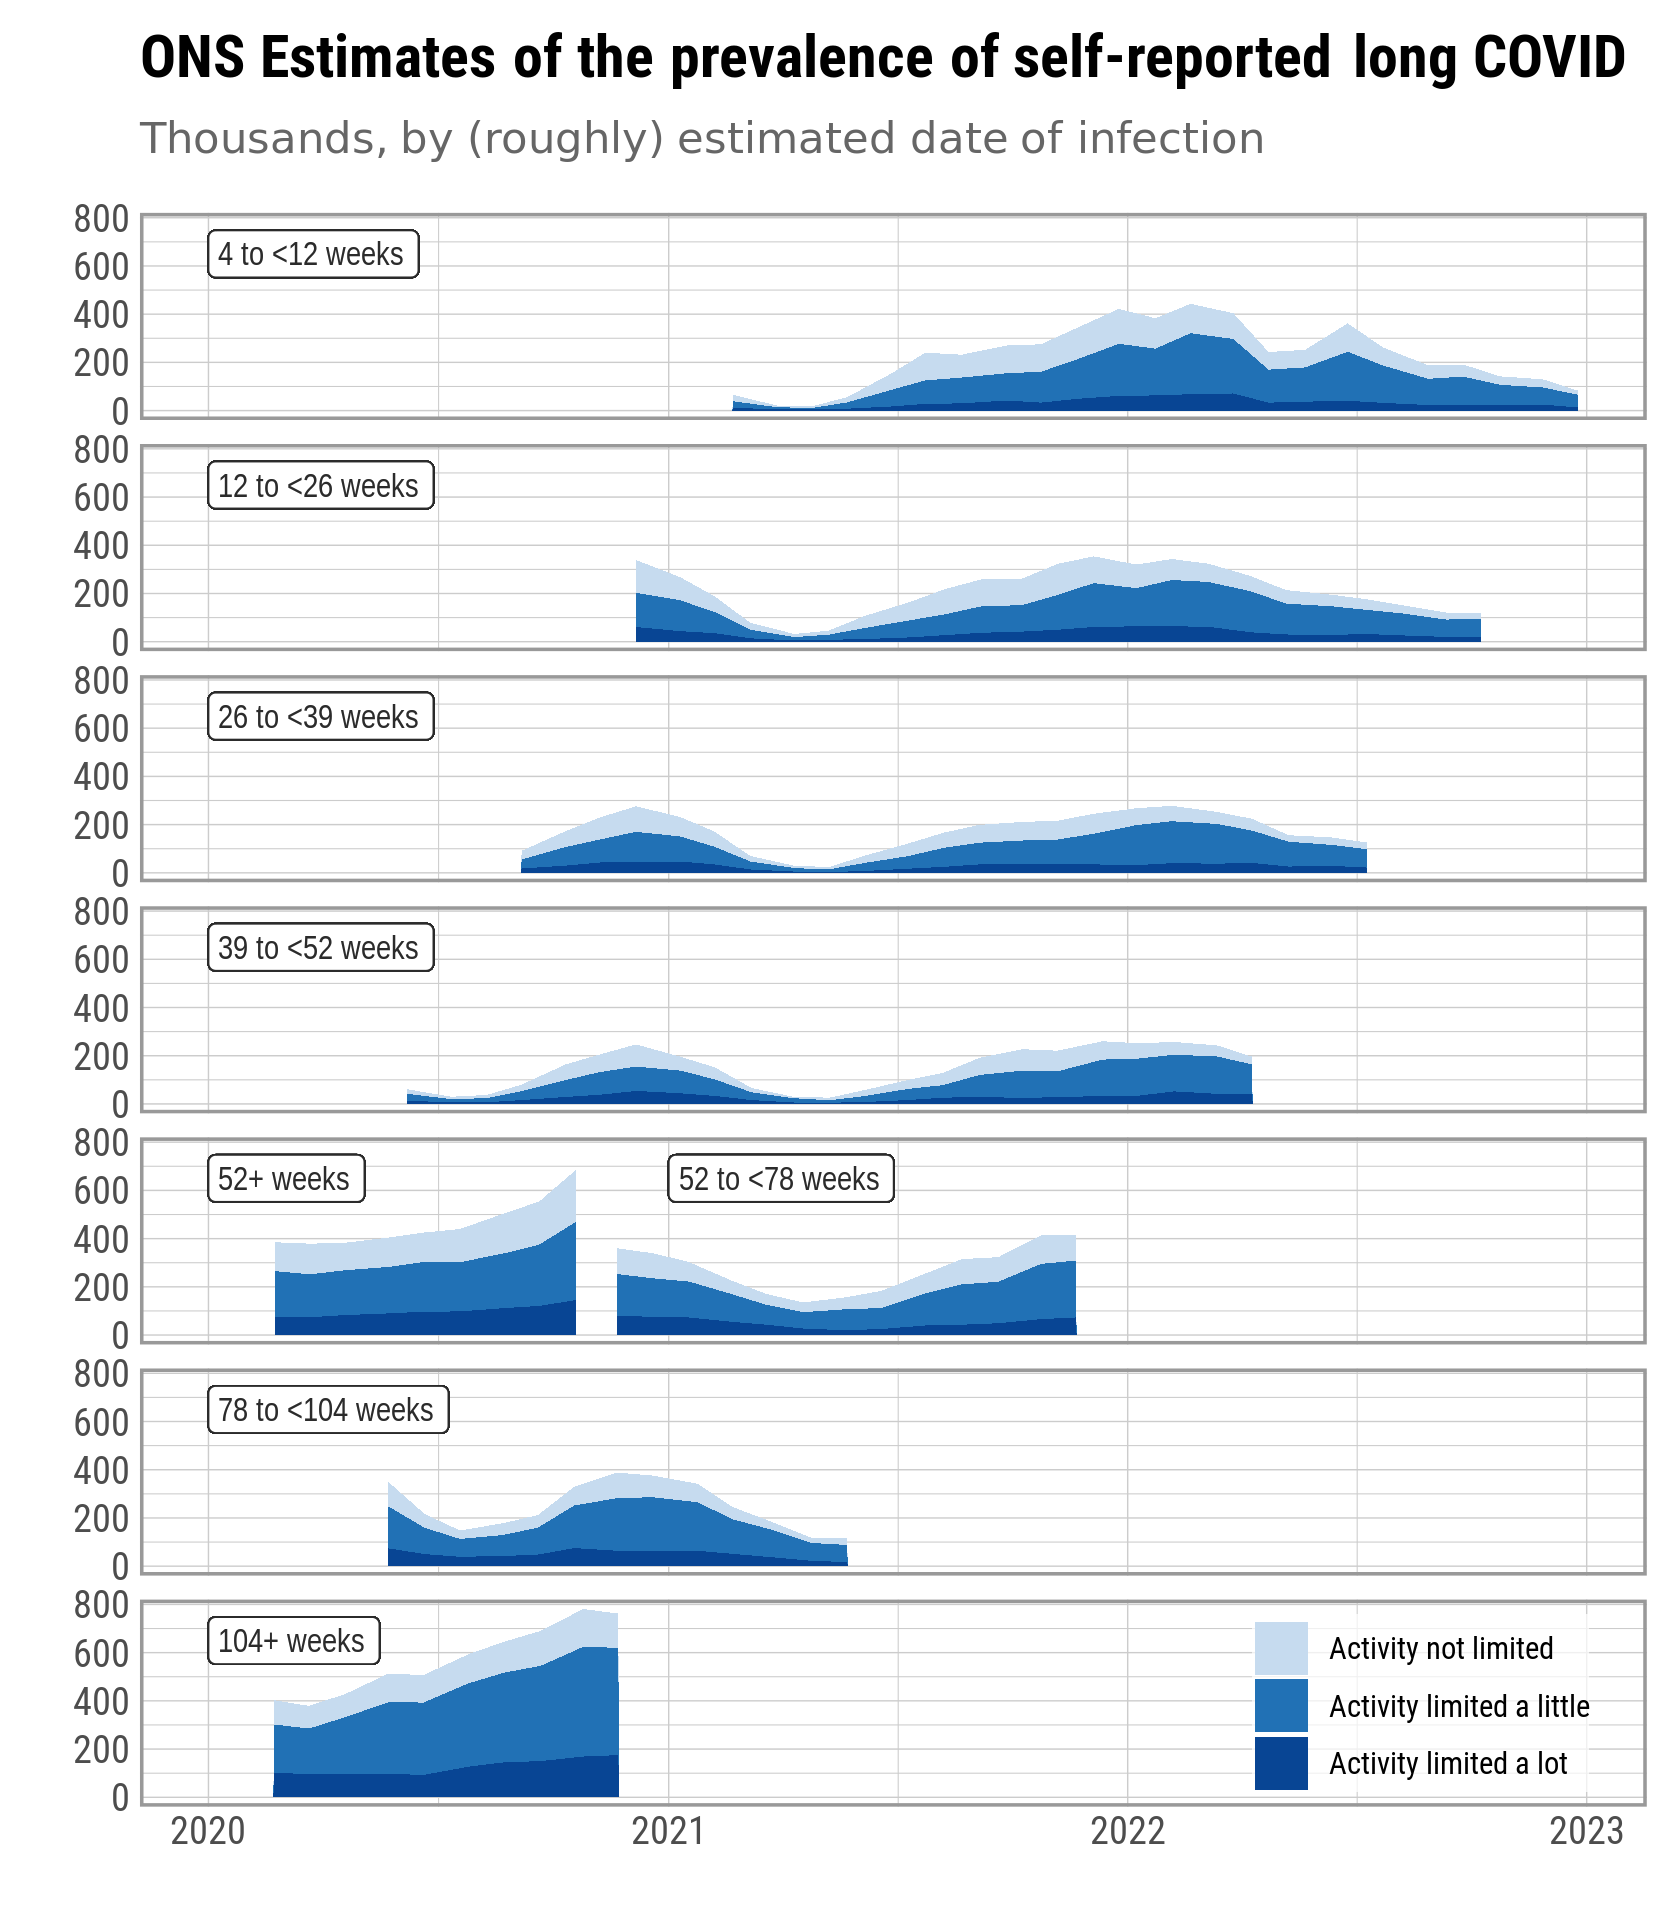

In [5]:
s = 1
options(repr.plot.width = s*7, repr.plot.height = s*8, repr.plot.res = 240/s)

df%>%
  merge(df_duration)%>%
  mutate(duration.avg = case_when(Group=="52+ weeks"~65,
                                  Group=="104+ weeks"~117,
                                                   T~duration.avg))%>%
  mutate(InfectionDate = midpoint_date-duration.avg*7)%>%
  mutate(cat = ifelse(Group == "52+ weeks", 5, Group))%>%
  mutate(label_pos = as.Date(ifelse(Group == "52 to <78 weeks", "2021-01-01", "2020-01-01")))%>%
  filter(InfectionDate >= "2020-02-01")%>%
  ggplot(aes(x = InfectionDate, y = Estimate,
             group = interaction(Group, `Impact on daily activity`),
             fill = `Impact on daily activity`)) + 
  labs(title = "ONS Estimates of the prevalence of self-reported long COVID",
       subtitle = "Thousands, by (roughly) estimated date of infection",
       fill = "", x = "", y = "") +
  geom_area() +
  scale_fill_manual(values = c('#C6DBEF',  '#2171B5', '#084594')) +
  scale_y_continuous(breaks = seq(0, 1000, 200)) +
  geom_label(aes(x = label_pos, y = 650, label = Group),
             hjust = 0, fill = "white", alpha = 0.8) +
  facet_wrap(cat~., ncol = 1)+ 
  theme(strip.background = element_blank(),
        strip.text.x = element_blank(),
        panel.spacing = unit(0.5, "lines"),
        panel.border = element_rect(color = "gray60", fill=NA, linewidth=1),
        legend.position = c(0.85, .065),
        legend.margin=margin(t = -.5, unit='cm'),
        legend.box.background = element_rect(fill = alpha("white", 0.7),
            colour = NA)) +
  savePlot("ONS_LC_date_of_infection")


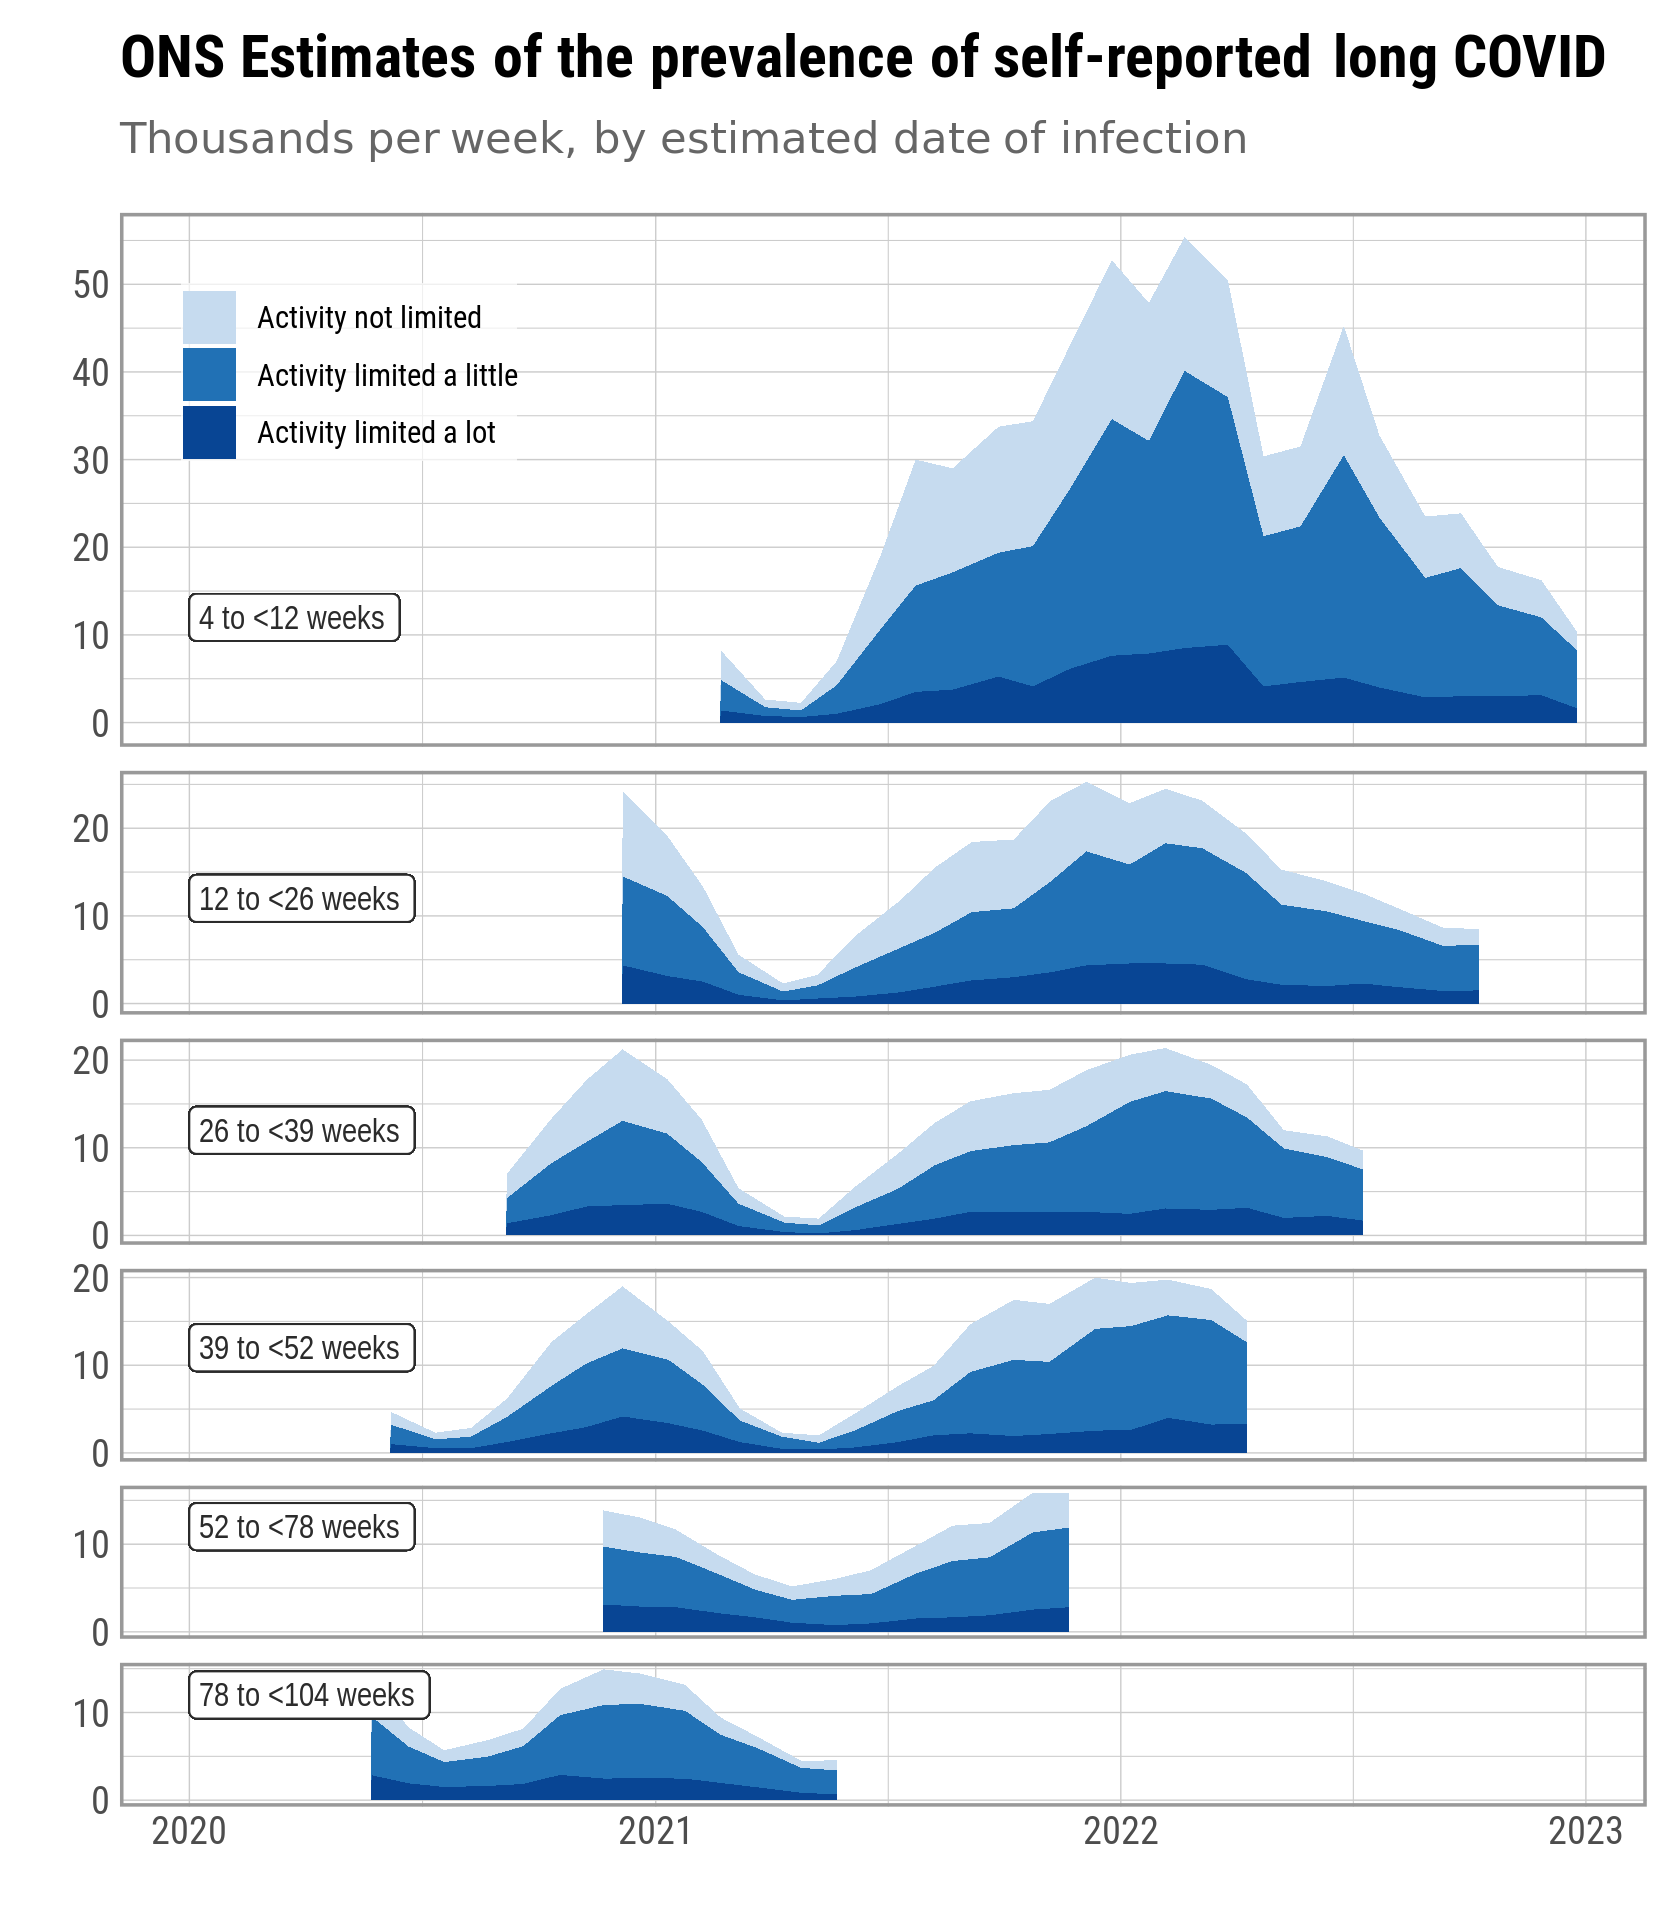

In [6]:
s = 1
options(repr.plot.width = s*7, repr.plot.height = s*8, repr.plot.res = 240/s)

df%>%
  merge(df_duration)%>%
  mutate(InfectionDate = midpoint_date-duration.avg*7)%>%
  filter(!is.na(duration.max))%>%
  mutate(duration = duration.max-duration.min)%>%
  filter(InfectionDate >= "2020-02-01")%>%
  ggplot(aes(x = InfectionDate, y = Estimate/duration)) + 
  labs(title = "ONS Estimates of the prevalence of self-reported long COVID",
       subtitle = "Thousands per week, by estimated date of infection",
       fill = "", x = "", y = "") +
  geom_area(aes(
             group = interaction(Group, `Impact on daily activity`),
             fill = `Impact on daily activity`)) +
  scale_fill_manual(values = c('#C6DBEF',  '#2171B5', '#084594')) +
  scale_y_continuous(breaks = seq(0, 100, 10)) +
  geom_label(aes(x = as.Date("2020-01-01"), y = 12, label = Group),
             hjust = 0, fill = "white", alpha = 0.8) +
  facet_grid(Group~., scale = "free_y", space = "free_y")+ 
  theme(strip.background = element_blank(),
        strip.text = element_blank(),
        panel.spacing = unit(0.5, "lines"),
        panel.border = element_rect(color = "gray60", fill=NA, linewidth=1),
        legend.position = c(0.15, .90),
        legend.margin=margin(t = -.5, unit='cm'),
        legend.box.background = element_rect(fill = alpha("white", 0.7),
            colour = NA)) +
  savePlot("ONS_LC_date_of_infection")

In [7]:
df_pos <-
  read_csv("data/ons_estimated_positive.csv", show_col_types = FALSE)%>%
  mutate(duration = NA, 
         Estimate = NA, 
         Group = "4 to <12 weeks",
        `Impact on daily activity` = "Activity limited a lot")
  
df_pos%>%
  head

est_positive,midpoint_date,duration,Estimate,Group,Impact on daily activity
<dbl>,<date>,<lgl>,<lgl>,<chr>,<chr>
0.27,2020-05-03,NA,NA,4 to <12 weeks,Activity limited a lot
0.25,2020-05-10,NA,NA,4 to <12 weeks,Activity limited a lot
0.24,2020-05-17,NA,NA,4 to <12 weeks,Activity limited a lot
0.10,2020-05-23,NA,NA,4 to <12 weeks,Activity limited a lot
0.06,2020-05-31,NA,NA,4 to <12 weeks,Activity limited a lot
0.06,2020-06-06,NA,NA,4 to <12 weeks,Activity limited a lot


In [8]:
tmp <-
  df%>%
  merge(df_duration)%>%
  mutate(midpoint_date = midpoint_date-duration.avg*7)%>%
  filter(!is.na(duration.max))%>%
  mutate(duration = duration.max-duration.min)%>%
  select(midpoint_date, Estimate, duration, Group, `Impact on daily activity`)%>%
  mutate(est_positive = NA)

tmp%>%tail

,midpoint_date,Estimate,duration,Group,Impact on daily activity,est_positive
,<date>,<dbl>,<int>,<fct>,<fct>,<lgl>
349,2020-09-19,48,26,78 to <104 weeks,Activity limited a lot,NA
350,2020-12-19,90,26,78 to <104 weeks,Activity not limited,NA
351,2020-08-22,42,26,78 to <104 weeks,Activity limited a lot,NA
352,2021-05-23,30,26,78 to <104 weeks,Activity not limited,NA
353,2020-07-19,35,26,78 to <104 weeks,Activity not limited,NA
354,2020-11-21,64,26,78 to <104 weeks,Activity limited a lot,NA


Warning message:
“Removed 147 rows containing non-finite values (`stat_align()`).”
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 354 rows containing non-finite values (`stat_smooth()`).”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“k-d tree limited by memory. ncmax= 200”
Warning message:
“Removed 147 rows containing non-finite values (`stat_align()`).”
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 354 rows containing non-finite values (`stat_smooth()`).”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“k-d tree limited by memory. ncmax= 200”
Warning message:
“Removed 147 rows containing non-finite values (`stat_align()`).”
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 354 rows containing non-finite values (`stat_smooth()`).”
Warning message in simpleLoess(y, x, w, span, degree =

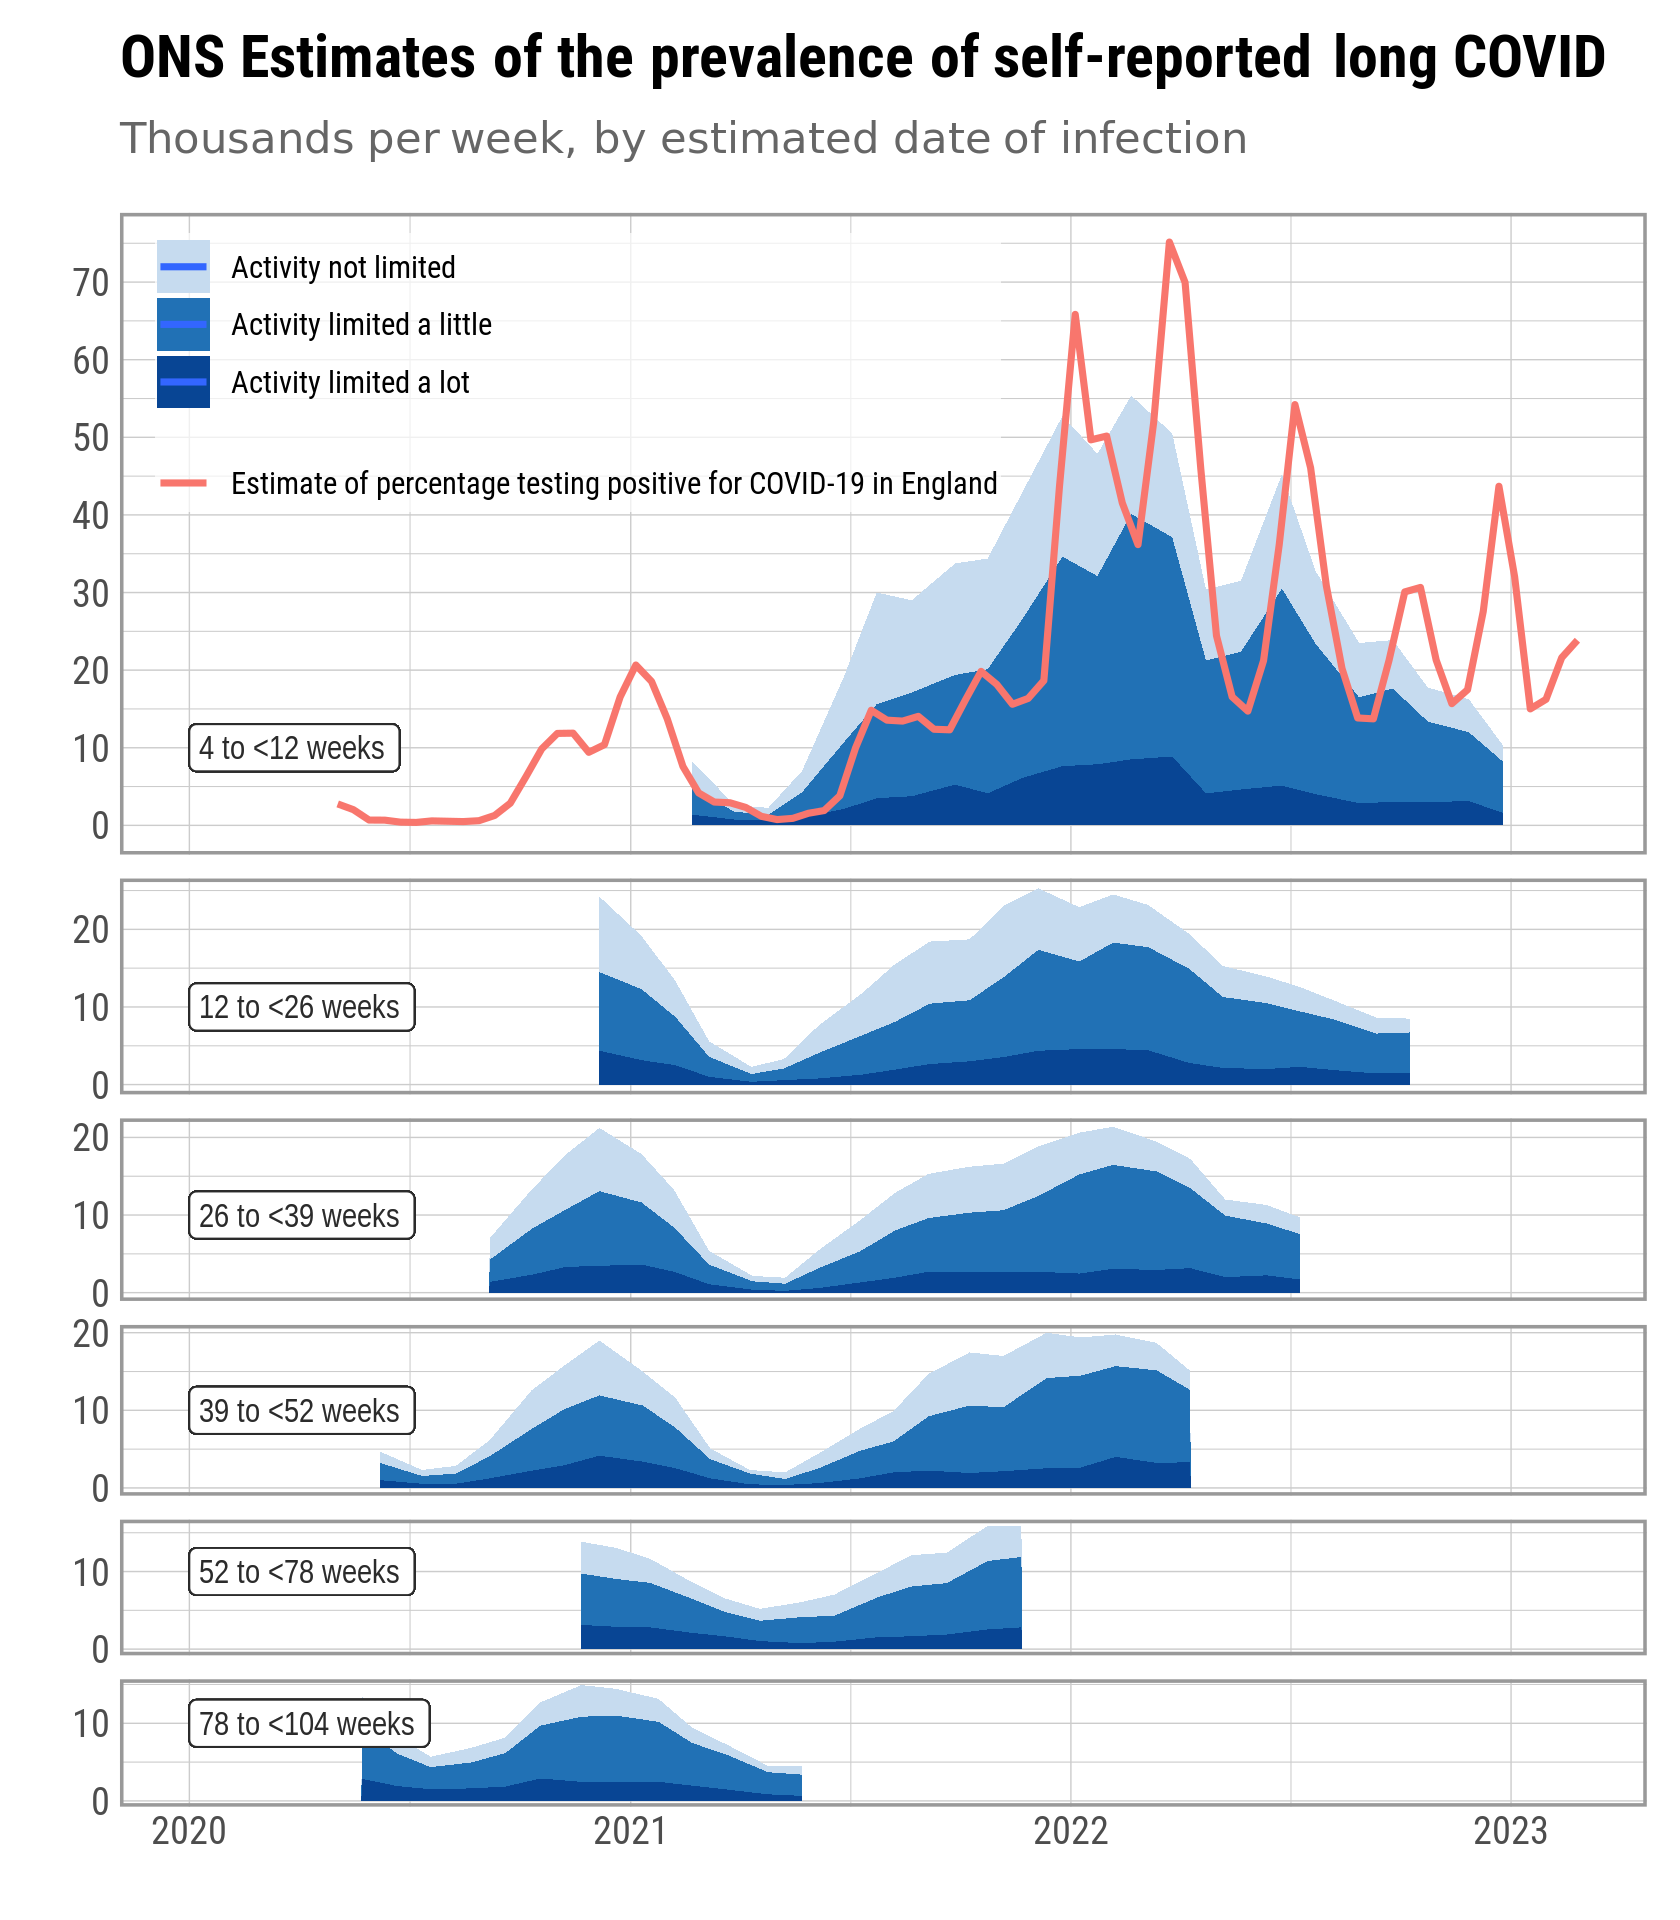

In [9]:
s = 1
options(repr.plot.width = s*7, repr.plot.height = s*8, repr.plot.res = 240/s)

tmp%>%
  rbind(df_pos)%>%
  ggplot(aes(x = midpoint_date, y = Estimate/duration)) + 
  labs(title = "ONS Estimates of the prevalence of self-reported long COVID",
       subtitle = "Thousands per week, by estimated date of infection",
       fill = "", color = "",  x = "", y = "") +
  geom_area(aes(group = interaction(Group, `Impact on daily activity`),
                fill = `Impact on daily activity`)) +
  scale_fill_manual(values = c('#C6DBEF',  '#2171B5', '#084594')) +
  scale_y_continuous(breaks = seq(0, 100, 10)) +
  geom_label(aes(x = as.Date("2020-01-01"), y = 10, label = Group),
             hjust = 0, fill = "white", alpha = 0.8) +
  geom_smooth(aes(y = est_positive*10, color = "Estimate of percentage testing positive for COVID-19 in England",
                  group ="Estimate of positive ...", fill = NULL),
              show.legend = T, se = F, span = 0.05) +
  facet_grid(Group~., scale = "free_y", space = "free_y")+ 
  theme(strip.background = element_blank(),
        strip.text = element_blank(),
        panel.spacing = unit(0.5, "lines"),
        panel.border = element_rect(color = "gray60", fill=NA, linewidth=1),
        legend.position = c(0.3, .90),
        legend.margin=margin(t = -.5, unit='cm'),
        legend.box.background = element_rect(fill = alpha("white", 0.7),
                                             colour = NA)) +
  savePlot("ONS_LC_date_of_infection")